In [90]:
import sys
import os
import time 
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm 
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pims
import scipy
import scipy.ndimage as nd
from scipy.ndimage import measurements
from scipy.optimize import curve_fit
from skimage.measure import regionprops
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import numba
from numba import jit, njit, prange, float64, int16, int64, uint16
from numba import types
from numba.typed import Dict
import emlab
from emlab.emio import emfile
from multiprocessing import Pool, Manager
import statsmodels.api as sm
from itertools import repeat

%matplotlib inline

In [2]:
matplotlib.style.use('default')
plt.rcParams.update({'font.size': 12})

In [300]:
plt.rcParams.update({'font.size': 10})

# Fine Calibration Process

We begin the calibration process by first finding out the appropriate common mode correction for the detector. Next, with the dark subtracted and common mode corrected flat-field illuminated dataset, we performed connected component analysis to identify signal-containing puddles. Counting the number of puddles with area larger than a predetermined threshold allows us to estimate the average electron events per pixel.

With the estimated average dosage per pixel per frame, we calculate the expected number of electron events for each pixel for a selected series of frames. For each pixel, we then ranked all the ADU values in the frame series and pick as many of the top ADU values as the expected number of electron events. The per pixel gain threshold can then be determined from the average of the smallest ADU value among the identified values, and the next smaller ADU value which is lower in rank. All the other events with ADU values lower than this threshold will be labeled as noise. Finally, connected component analysis is perform for each frame after applying the gain threshold, and the number of electron puddles counted gives us the electron dose rate per pixel per frame. 

## Determining common mode for detector
This dataset consist of dark reference frames using DE16 detector. Through observing the pairwise temporal correlation between pixels, we can determine the common mode fluctuations.

In [3]:
data = np.load('./examples/darkdata_6k4.npy',allow_pickle=True)

In [4]:
data.shape

(6400, 512, 4096)

##### We perform PCA on the pairwise correlation matrix, and group the reduced dataset using K-means clustering to visualize the common mode.

In [5]:
data_4by1024 = data[:,108:108+4,2816:2816+1024].reshape(6400,4*1024)
data_4by1024corr = np.corrcoef(data_4by1024.T)
data_4by1024corrpca = PCA(svd_solver='full',n_components=8).fit_transform(data_4by1024corr)

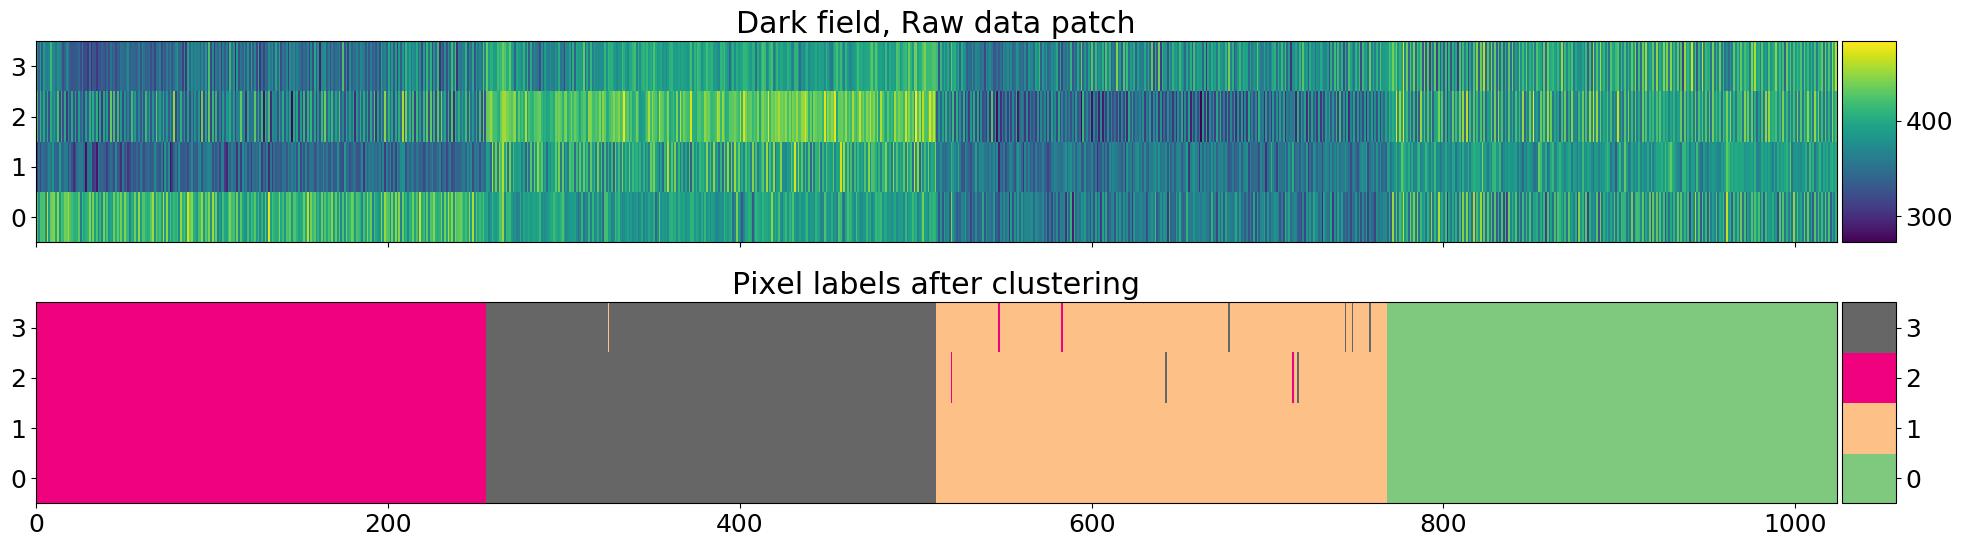

In [162]:
f,ax = plt.subplots(2,1,figsize=(24,6),sharex=True, gridspec_kw={'hspace': 0.3, 'wspace': 0.01})

im0 = ax[0].imshow((data[:,108:112,2816:3840].mean(axis=0)), aspect='auto', origin='lower')
ax[0].set_title('Dark field, Raw data patch')
div = make_axes_locatable(ax[0])
cax = div.append_axes("right", size="3%", pad=0.05)
f.colorbar(im0,cax=cax, pad=0.005)

im1 = ax[1].imshow(data_4by1024corrpcakmeans.labels_.reshape(4,1024),cmap = plt.get_cmap("Accent"), aspect='auto', origin='lower')
ax[1].set_title('Pixel labels after clustering')  
div1 = make_axes_locatable(ax[1])
cax1 = div1.append_axes("right", size="3%", pad=0.05)
f.colorbar(im1,cax=cax1, pad=0.005,cmap = plt.get_cmap("Accent"),values=np.arange(4).tolist(),ticks=np.arange(4).tolist())

In [58]:
data_2by512 = data[:,108:108+2,2816:2816+512].reshape(6400,2*512)
data_2by512corr = np.corrcoef(data_2by512.T)
data_2by512corrpca = PCA(svd_solver='full',n_components=8).fit_transform(data_2by512corr)

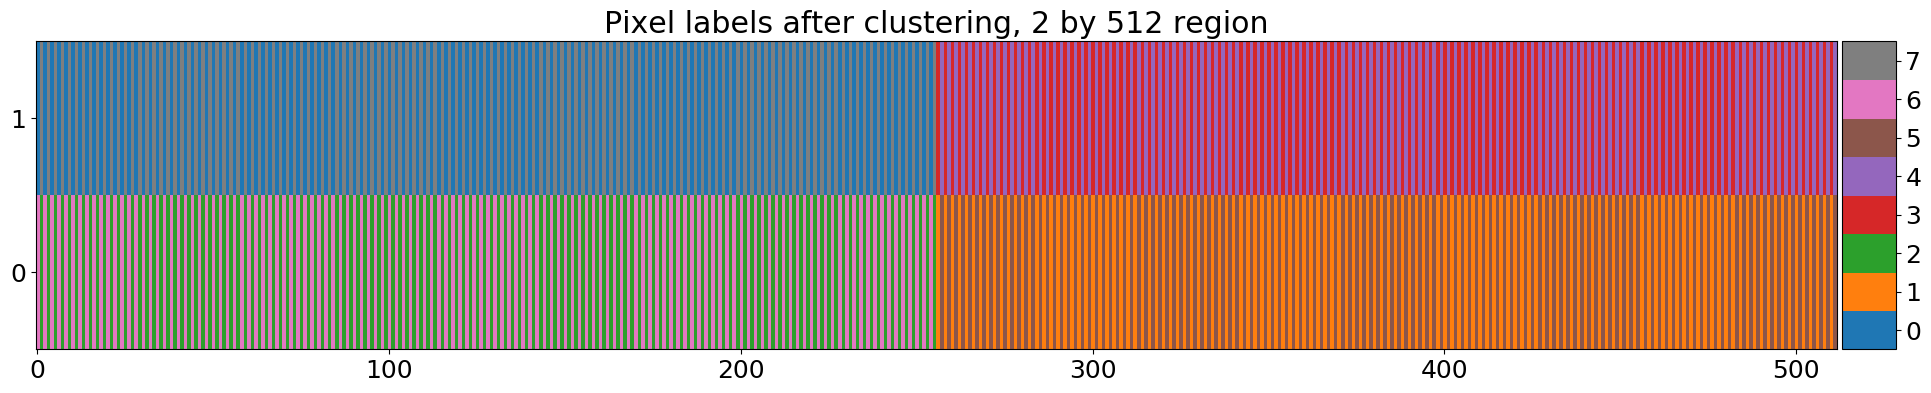

In [163]:
f,ax = plt.subplots(1,1,figsize=(24,4),sharex=True, gridspec_kw={'hspace': 0.3, 'wspace': 0.01})
cmap_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

im0 = ax.imshow(data_2by512corrpcakmeans.labels_.reshape(2,512), cmap = matplotlib.colors.ListedColormap(['C0','C1','C2','C3','C4','C5','C6','C7']), aspect='auto', origin='lower')
ax.set_title('Pixel labels after clustering, 2 by 512 subregion') 
ax.set_yticks([0,1])
div = make_axes_locatable(ax)
cax = div.append_axes("right", size="3%", pad=0.05)
f.colorbar(im0,cax=cax, pad=0.005, cmap = matplotlib.colors.ListedColormap(['C0','C1','C2','C3','C4','C5','C6','C7']),values=np.arange(8).tolist())

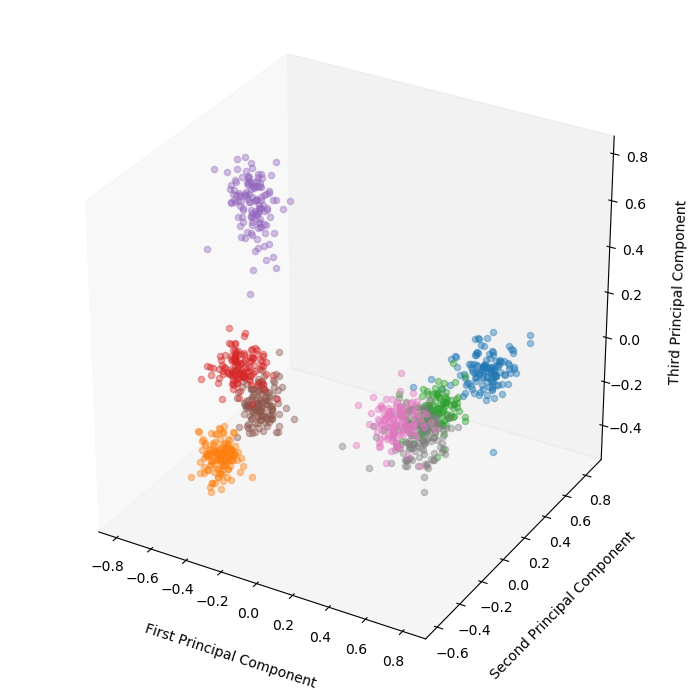

In [211]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

for n,k in enumerate(data_2by512corrpcakmeans.labels_):
    ax.scatter(data_2by512corrpca[n,0],data_2by512corrpca[n,1],data_2by512corrpca[n,2],c='C{}'.format(k),alpha=0.4)

ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

ax.set_zlabel('Third Principal Component',labelpad = 15)
ax.set_ylabel('Second Principal Component',labelpad = 15)
ax.set_xlabel('First Principal Component',labelpad = 15)
plt.tight_layout()

## Performing dark subtraction and common mode correction
The median value for each pixel across a series of 3200 calibration frames is used to estimate the dark noise, and the median value of pixels in alternating columns in 1 by 256 blocks is used for common mode correction.

##### Loading a flat-field illuminated dataset 

In [5]:
fname = "./examples/15-08-57.560_120K.seq"

In [7]:
with emfile(fname, "seq", mode="r") as f:
    print('Dim:{}'.format(f.shape))
    bdata = f[6400:6400+3200,:,:]

Dim:(65534, 512, 4000)


In [8]:
bdata = bdata.data

##### Calculating per pixel median for dark subtraction

In [9]:
@njit(parallel=True,fastmath=True)
def find_median(arr):
    med = np.empty((arr.shape[1]))
    for r in prange(arr.shape[1]):
        med[r] = np.median(arr[:,r])
    return med

In [10]:
t = time.time()
bmed = find_median(bdata[:,:,:].reshape(3200,512*4000))
print('median: {:.3f}s'.format(time.time()-t))

median: 10.657s


In [11]:
@njit(parallel=True)
def arrsubt(arr,median_arr):
    arr_out = np.empty((arr.shape[0],arr.shape[1]*arr.shape[2]))
    arr_flat = arr.reshape(arr.shape[0],arr.shape[1]*arr.shape[2])
    
    for f in prange(arr.shape[0]):
        for p in prange(median_arr.shape[0]):
            arr_out[f,p] = arr_flat[f,p]-median_arr[p]            
    return arr_out.reshape(arr.shape[0],arr.shape[1],arr.shape[2])

In [12]:
t = time.time()
bdata_bmed = arrsubt(bdata,bmed) 
print('bdata_bmed: {:.3f}s'.format(time.time()-t))

bdata_bmed: 2.418s


##### Common mode correction with median subtraction from alternating columns in 1 by 256 blocks

In [13]:
@njit(parallel=True)
def medsubframe1by256alt(data):
    data_medsub4by256 = np.zeros((data.shape[0],data.shape[1],data.shape[2]))
    for f in prange(data.shape[0]):
        for r in prange(data.shape[1]):
            for c in np.arange(0,data.shape[2],256):
                data_medsub4by256[f,r,c:c+256:2] = data[f,r,c:c+256:2] - np.median(data[f,r,c:c+256:2])
                data_medsub4by256[f,r,c+1:c+256:2] = data[f,r,c+1:c+256:2] - np.median(data[f,r,c+1:c+256:2])     
    return data_medsub4by256            

In [14]:
t = time.time()
bdata_bmed_medsub1by256altframe = medsubframe1by256alt(bdata_bmed)
print('Common mode correction: {:.3f}s'.format(time.time()-t)) 

Common mode correction: 50.801s


In [15]:
data_maxrows = bdata_bmed_medsub1by256altframe.shape[1]

In [16]:
data_maxcols = bdata_bmed_medsub1by256altframe.shape[2]

## Determining global intensity threshold
We tabulated all the intensity values of the dataset in a histogram and fitted it with a Normal distribution. We select a constant multiple of standard deviations from the mean as the threshold for differentiating signal from noise.

In [17]:
@njit
def histbincount(arr):
    arr_int = np.asarray(arr,dtype=np.int64)
    arr_int_min = np.min(arr_int)
    arr_int_po = arr_int+np.abs(arr_int_min)
    return arr_int_min,np.bincount(arr_int_po)

In [18]:
t = time.time()
bdata_bmed_medsub1by256altframehist = histbincount(bdata_bmed_medsub1by256altframe.ravel())
print('hist: {:.3f}s'.format(time.time()-t)) 

hist: 57.127s


In [19]:
def normfunc(x, a, b, c):
    return a * np.exp(-((x-b)**2)/(2*c**2)) 

In [398]:
fit_range = np.abs(bdata_bmed_medsub1by256altframehist[0])
popt_bml, pcovl = curve_fit(normfunc, np.arange(-fit_range,np.argmax(bdata_bmed_medsub1by256altframehist[1])-fit_range+1), 
                            bdata_bmed_medsub1by256altframehist[1][:np.argmax(bdata_bmed_medsub1by256altframehist[1])+1]
                            ,bounds=([1e8,-1,0],[1e11,1,10]))
perr = np.sqrt(np.diag(pcovl))
print('Amp:{:.3e}({:1.0e}),'.format(*(popt_bml[0],perr[0])),'mean:{:.2f}({})ADU,'.format(*(popt_bml[1],round(perr[1],2))),'std dev:{:.2f}({})ADU'.format(*(popt_bml[2],round(perr[2],2))))

Amp:1.398e+09(4e+06), mean:0.48(0.02)ADU, std dev:2.25(0.01)ADU


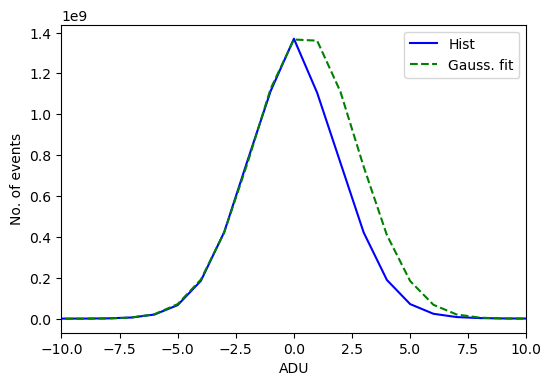

In [400]:
plt.figure(figsize=(6,4))
x = np.arange(-fit_range,fit_range)
y = bdata_bmed_medsub1by256altframehist[1][:fit_range*2]
plt.plot(x, y, 'b-', label='Hist')
plt.plot(x, normfunc(x, *popt_bml), 'g--',label='Gauss. fit')
plt.xlim(-10,10)
plt.xlabel('ADU')
plt.ylabel('No. of events')
plt.legend()

## Estimating average number of events per pixel
We perform connected component analysis on pixels which passes the global threshold. Next, we count the number of labeled electron puddles that satisfy the minimum area constraint to estimate the number of events per pixel.

##### Here we load a pre-generated list with the randomly selected 500 frames. For the connected component analysis, we used 4 standard deviations from the mean as the global threshold.

In [22]:
idx = np.load('./examples/idx_500.npy')

In [23]:
def get_puddle_features(data, thresh=4):
    
    s = np.ones((3,3))
    
    dark_subtracted = data 
    bin_map = dark_subtracted>thresh
    labels = measurements.label(bin_map,s)[0]
    labellist = np.arange(1,labels.max()+1)
    area = measurements.labeled_comprehension(bin_map, labels, labellist, np.sum, float, 0)
    label_pos = np.where(area>=0)[0]
    sig_labels = labellist[label_pos]
    maxpos = measurements.maximum_position(dark_subtracted, labels, sig_labels)
    mass = measurements.labeled_comprehension(dark_subtracted, labels, sig_labels, np.sum, float, 0)
    vam_li = []
    for v,a,m in zip(maxpos,area,mass):
        vam_li.append(np.hstack((v,a,m)))

    return vam_li

In [24]:
arr_list = []
for arr in bdata_bmed_medsub1by256altframe[idx[:500]]:
    arr_list.append(arr)

In [27]:
sigma = popt_bml[1]+4*popt_bml[2]
t = time.time() 
with Pool() as pool: 
    rs = pool.starmap(get_puddle_features,zip(arr_list,repeat(sigma)))
    pool.close()
    pool.join()
print('threshold: {:.3f} ADU, Counting 500 frames: {:.3f}s'.format(sigma,time.time()-t)) #14s

threshold: 9.465 ADU, Counting 500 frames: 20.709s


In [28]:
bdata_bmedrdm500_count = dict(zip(np.arange(500), [r for r in rs]))

##### A small region of each frame is selected for estimating the average dose per pixel per frame, and only events with area larger than the minimum area threshold are counted. Here, the minimum area chosen is 1 pixel.

In [29]:
bdata_bmedrdm500_count_area = {}
for frame,val in bdata_bmedrdm500_count.items():
    bdata_bmedrdm500_count_area[frame] = 0
    for labeledprop in val:
        if labeledprop[1]>=2200 and labeledprop[2]>1:
            bdata_bmedrdm500_count_area[frame] +=1

In [410]:
np.mean([counts for key,counts in bdata_bmedrdm500_count_area.items()])

94.582

In [31]:
bdata_bmedrdm500_count_areaperpx = np.mean([counts for key,counts in bdata_bmedrdm500_count_area.items()])/ \
                                    (data_maxrows*(data_maxcols-2200))
print('Est Dose:{:.2e} events/px/frame'.format(bdata_bmedrdm500_count_areaperpx))

Est Dose:1.03e-04 events/px/frame


## Determining per pixel gain threshold
With the estimated average dosage per pixel per frame, we select the top few events with the largest ADU corresponding to the expected number of electron events for a given number of frames. The per pixel gain threshold is then determined from the average of this value and the next smaller ADU value.

##### We repeat the average dose rate estimation for a few set of frames to obtain a more accurate value. Here we load the pre-calculated average dose rates for 5 sets of 3200 frames, similarly estimated from the randomly selected 500 frames within each set. 

In [32]:
counted_mean_all_120K = np.load('./examples/120K_counted_mean_all_4s_6d4kto19d2k.npy')

In [20]:
counted_mean_all_120K

array([94.582, 94.624, 94.378, 93.982, 94.662])

##### We use the mean of the 5 dose rates to estimate the number of top events that should be selected, given a the maximum number of frames, 65534 for this dataset.

In [34]:
max_frames_120K = 65534

In [35]:
bdata_bmedrdm500_count_areaperpxavg = counted_mean_all_120K.mean()/(data_maxrows*(data_maxcols-2200))

In [36]:
topNevents120K = int(np.floor(max_frames_120K*bdata_bmedrdm500_count_areaperpxavg))
minframes120K = int(np.ceil(topNevents120K/bdata_bmedrdm500_count_areaperpxavg))
print('No. of top events: {}, '.format(topNevents120K),
      'Min. no. of frames needed: {}'.format(minframes120K))

No. of top events: 6,  Min. no. of frames needed: 58548


In [37]:
countsnframeslist = [(topNevents120K,minframes120K)]

In [38]:
t = time.time()
with emfile(fname, "seq", mode="r") as f:
    print('Dim:{}'.format(f.shape))
    bdata = f[:countsnframeslist[0][1],:,1792:]
    f.close()
    
bdatafull = bdata.data
print('Load: {:.3f}s'.format(time.time()-t))

Dim:(65534, 512, 4000)
Load: 355.508s


##### Here, we calculate the per pixel median for the first 3200 frames of the dataset for dark subtraction.

In [39]:
t = time.time()
bmedfull = find_median(bdatafull[:3200,:,:].reshape(3200,data_maxrows*(data_maxcols-1792)))
print('bmed: {:.3f}s'.format(time.time()-t))

bmed: 4.794s


##### In order for easier processing and storage, we split the dataset into sets of 10000 frames. Furthermore, the region of interest is limited to only from columns 1792 onwards so that the region processed coincides with the start of a 1 by 256 block for common mode correction. We also further break up the dataset column-wise into 6 groups for processing due to memory constraint. The dataset can be broken up into more groups if necessary, either frame-wise or column-wise. Processed data files are saved and loaded intermittently. 

In [40]:
fendlist = ['_f1','_f2','_f3','_f4','_f5','_f6','_f7']

In [41]:
pxendlist = ['_px1','_px2','_px3','_px4','_px5','_px6']

In [42]:
splitpxnum = (data_maxcols-1792)//6

##### Here we create a folder in the current working directory, titled "pyReCoDe_data", to store the processed data file

In [43]:
curr_wd = os.getcwd()
savepathset = os.path.join(curr_wd,'pyReCoDe_data')
if not(os.path.exists(savepathset)):
    os.mkdir(savepathset)

In [44]:
fnameprefix = fname.split('_')[-1].split('.')[0]

In [45]:
for n,pxend in enumerate(pxendlist):
    t = time.time()
    bmedfull_crop = np.reshape(bmedfull.reshape(data_maxrows,
                                      data_maxcols-1792)[:,(n*splitpxnum):(n*splitpxnum)+splitpxnum],splitpxnum*data_maxrows)
    bdatafull_crop = bdatafull[:,:,(n*splitpxnum):(n*splitpxnum)+splitpxnum]
    bdatafull_bmed = arrsubt(bdatafull_crop.copy(),bmedfull_crop) 
    print('bdata_bmed{}: {:.3f}s'.format(pxend,time.time()-t))
    print('Saving '+fnameprefix
          +'_bdatafull_bmed_f{}'.format(countsnframeslist[0][1])+'_512_1792'+'_{}{}'.format(splitpxnum,pxend)+'...')
    np.save(os.path.join(savepathset,fnameprefix)
            +'_bdatafull_bmed_f{}'.format(countsnframeslist[0][1])+'_512_1792'+'_{}{}'.format(splitpxnum,pxend)+'.npy',bdatafull_bmed)

bdata_bmed_px1: 19.644s
Saving 120K_bdatafull_bmed_f58548_512_1792_368_px1...
bdata_bmed_px2: 91.218s
Saving 120K_bdatafull_bmed_f58548_512_1792_368_px2...
bdata_bmed_px3: 32.985s
Saving 120K_bdatafull_bmed_f58548_512_1792_368_px3...
bdata_bmed_px4: 59.440s
Saving 120K_bdatafull_bmed_f58548_512_1792_368_px4...
bdata_bmed_px5: 22.070s
Saving 120K_bdatafull_bmed_f58548_512_1792_368_px5...
bdata_bmed_px6: 31.262s
Saving 120K_bdatafull_bmed_f58548_512_1792_368_px6...


In [46]:
def splitloadnmedsub(fname,fendlist,pxendlist):
    
    for fn,fend in enumerate(fendlist):
        bdata_bmed_368 = {}
        for n,pxend in enumerate(pxendlist):
            t = time.time()
            print(fname.split('/')[-1].split('.')[0]+pxend)
            bdata_bmed_368[n] = np.load(fname+pxend+'.npy',allow_pickle=True,mmap_mode='r')[(fn*10000):(fn*10000)+10000,:,:]
            print('Shape:{},'.format(bdata_bmed_368[n].shape), 't:{:.3f}s'.format(time.time()-t))
        
        t = time.time()
        bdata_bmed = np.concatenate([bdata_bmed_368[n] for n,pxend in enumerate(pxendlist)],axis=2)
        print('Shape:{},'.format(bdata_bmed.shape), 't:{:.3f}s'.format(time.time()-t))

        del bdata_bmed_368
        
        t = time.time()
        bdata_bmed_medsub1by256altframe = medsubframe1by256alt(bdata_bmed[:,:,:])
        print('CM:{:.3f}s'.format(time.time()-t))
        print('Saving '+fname+'_medsub1by256'+fend+'...')
        np.save(fname+'_medsub1by256'+fend+'.npy',bdata_bmed_medsub1by256altframe)
        
        del bdata_bmed
        del bdata_bmed_medsub1by256altframe

In [47]:
splitloadnmedsub(os.path.join(savepathset,fnameprefix)
                 +'_bdatafull_bmed_f{}'.format(countsnframeslist[0][1])+'_512_1792'+'_{}'.format(splitpxnum),
                         fendlist,pxendlist)

120K_bdatafull_bmed_f58548_512_1792_368_px1
Shape:(10000, 512, 368), t:0.074s
120K_bdatafull_bmed_f58548_512_1792_368_px2
Shape:(10000, 512, 368), t:0.004s
120K_bdatafull_bmed_f58548_512_1792_368_px3
Shape:(10000, 512, 368), t:0.067s
120K_bdatafull_bmed_f58548_512_1792_368_px4
Shape:(10000, 512, 368), t:0.085s
120K_bdatafull_bmed_f58548_512_1792_368_px5
Shape:(10000, 512, 368), t:0.079s
120K_bdatafull_bmed_f58548_512_1792_368_px6
Shape:(10000, 512, 368), t:0.004s
Shape:(10000, 512, 2208), t:255.885s
CM:146.038s
Saving /gpfs0/home/ngkianfong/For_KianFong/DE16_data/pyReCoDe_data/120K_bdatafull_bmed_f58548_512_1792_368_medsub1by256_f1...
120K_bdatafull_bmed_f58548_512_1792_368_px1
Shape:(10000, 512, 368), t:0.104s
120K_bdatafull_bmed_f58548_512_1792_368_px2
Shape:(10000, 512, 368), t:0.101s
120K_bdatafull_bmed_f58548_512_1792_368_px3
Shape:(10000, 512, 368), t:0.086s
120K_bdatafull_bmed_f58548_512_1792_368_px4
Shape:(10000, 512, 368), t:0.097s
120K_bdatafull_bmed_f58548_512_1792_368_px5
S

In [48]:
@njit(fastmath=True) #(parallel=True)
def wirthselectnp(a, k):
    a = a.copy()
    l = 0
    m = a.shape[0] - 1
    while l < m:
        x = a[k]
        i = l
        j = m
        while 1:
            while a[i] < x: i += 1
            while x < a[j]: j -= 1
            if i <= j:
                tmp = a[i]
                a[i] = a[j]
                a[j] = tmp
                i += 1
                j -= 1
            if i > j: break
        if j < k: l = i
        if k < i: m = j

    return a

In [49]:
@njit(parallel=True)
def findtopk(arr,k):
    top_k = np.zeros(arr.shape[1])
    for p in prange(arr.shape[1]):
        top_k[p] = wirthselectnp(arr[:,p],arr.shape[0]-k)[arr.shape[0]-k]
    return top_k   

In [50]:
def gainthresh(fname,fendlist,topN,n_frames,data_cols=4000-1792,cols_split_size=368,data_rows=512):
    
    bdata_medsub1by256altframe_368full = np.zeros((data_rows,data_cols))
    
    for c in np.arange(0,data_cols,cols_split_size):
        
        bdata_bmed_medsub1by256altframe = {}
        
        t = time.time()
        for fend in fendlist:
            bdata_bmed_medsub1by256altframe[fend] = np.load(fname+fend+'.npy',allow_pickle=True,mmap_mode='r')[:,:,c:c+cols_split_size]
        print('Load cols: {:.3f}s'.format(time.time()-t))
        
        t = time.time()
        bdata_medsub1by256altframe_368 = np.concatenate([bdata_bmed_medsub1by256altframe[fend] for fend in fendlist],axis=0)
        print('Dim:{}'.format(bdata_medsub1by256altframe_368.shape),'t: {:.3f}s'.format(time.time()-t))
        
        if bdata_medsub1by256altframe_368.shape[0] != n_frames:
            bdata_medsub1by256altframe_368 = bdata_medsub1by256altframe_368[:n_frames,:,:]
            print('Insuff. frames',bdata_medsub1by256altframe_368.shape)

            
        bdata_bmed_medsub1by256altframe = {} 
        
        t = time.time()
        bdata_topNthresh = findtopk(bdata_medsub1by256altframe_368.reshape(bdata_medsub1by256altframe_368.shape[0]
                                                                                 ,bdata_medsub1by256altframe_368.shape[1]*bdata_medsub1by256altframe_368.shape[2]),topN)
        bdata_topNp1thresh = findtopk(bdata_medsub1by256altframe_368.reshape(bdata_medsub1by256altframe_368.shape[0]
                                                                                 ,bdata_medsub1by256altframe_368.shape[1]*bdata_medsub1by256altframe_368.shape[2]),topN+1)
        
        del bdata_medsub1by256altframe_368
        
        bdata_topNNp1thresh = (0.5*(bdata_topNthresh+bdata_topNp1thresh)).reshape(512,bdata_topNthresh.shape[0]//512)
        print('Thresh: {:.3f}s'.format(time.time()-t))
        
        bdata_medsub1by256altframe_368full[:,c:c+cols_split_size] = bdata_topNNp1thresh
    
    return bdata_medsub1by256altframe_368full

In [52]:
t = time.time()
bdata_bmed_1792_medsub1by256_topNNp1threshcomb = gainthresh(os.path.join(savepathset,fnameprefix)
                                                            +'_bdatafull_bmed_f{}'.format(countsnframeslist[0][1])+'_512_1792'+'_{}'.format(splitpxnum)+'_medsub1by256'
                                                        ,fendlist
                                                        ,topN=countsnframeslist[0][0]
                                                        ,n_frames=countsnframeslist[0][1]
                                                        ,data_cols=data_maxcols-1792
                                                        ,cols_split_size=splitpxnum
                                                        ,data_rows=data_maxrows)

print('Dim: {}'.format(bdata_bmed_1792_medsub1by256_topNNp1threshcomb.shape)
      ,'t: {:.3f}s'.format(time.time()-t))

print('Saving '+fnameprefix+'_medsub1by256'
      +'_bdatafull_bmed_1792f{}'.format(countsnframeslist[0][1])+'_top{}{}'.format(countsnframeslist[0][0],countsnframeslist[0][0]+1)
        +'_medsub1by256'+'thresh'+'...')
np.save(os.path.join(savepathset,fnameprefix)
        +'_bdatafull_bmed_1792f{}'.format(countsnframeslist[0][1])+'_top{}{}'.format(countsnframeslist[0][0],countsnframeslist[0][0]+1)
        +'_medsub1by256'+'thresh'+'.npy',
        bdata_bmed_1792_medsub1by256_topNNp1threshcomb)

Load cols: 0.727s
Dim:(58548, 512, 368) t: 625.755s
Thresh: 37.927s
Load cols: 0.421s
Dim:(58548, 512, 368) t: 603.063s
Thresh: 46.336s
Load cols: 0.427s
Dim:(58548, 512, 368) t: 799.990s
Thresh: 50.490s
Load cols: 0.417s
Dim:(58548, 512, 368) t: 789.230s
Thresh: 47.667s
Load cols: 0.428s
Dim:(58548, 512, 368) t: 859.462s
Thresh: 49.295s
Load cols: 0.399s
Dim:(58548, 512, 368) t: 814.277s
Thresh: 51.192s
Dim: (512, 2208) t: 4798.368s
Saving 120K_medsub1by256_bdatafull_bmed_1792f58548_top67_medsub1by256thresh...


## Calculating electron dose rate per pixel per frame
We repeat the connected component analysis for each frame after implementing the per pixel gain threshold. The number of electron puddles counted gives us the electron dose rate per pixel per frame. 

##### Here we calculate the electron dose rate per pixel per frame for the same 3200 frames as before.

In [53]:
fend = '_f1'

t = time.time()

bdata_bmed_medsub1by256altframe_f = np.load(os.path.join(savepathset,fnameprefix)
                                            +'_bdatafull_bmed_f{}'.format(countsnframeslist[0][1])+'_512_1792'+'_{}'.format(splitpxnum)
                                            +'_medsub1by256'+fend+'.npy'
                                            ,allow_pickle=True,mmap_mode='c')[6400:6400+3200,:,:]

print('Load data:{}'.format(bdata_bmed_medsub1by256altframe_f.shape),'t: {:.3f}s'.format(time.time()-t))

Load data:(3200, 512, 2208) t: 0.105s


In [54]:
t = time.time()

bdata_bmed_medsub1by256_1792_topNNp1threshcomb = np.load(os.path.join(savepathset,fnameprefix)
                                                         +'_bdatafull_bmed_1792f{}'.format(countsnframeslist[0][1])+'_top{}{}'.format(countsnframeslist[0][0],countsnframeslist[0][0]+1)
                                                         +'_medsub1by256'+'thresh'+'.npy'
                                                        ,allow_pickle=True)

print('Load thresh:{}'.format(bdata_bmed_medsub1by256_1792_topNNp1threshcomb.shape),'t: {:.3f}s'.format(time.time()-t))

Load thresh:(512, 2208) t: 0.008s


In [55]:
arrf_list = []
for arr in bdata_bmed_medsub1by256altframe_f:
    arrf_list.append(arr)

In [56]:
t = time.time()

with Pool() as pool:
    rsf = pool.starmap(get_puddle_features,zip(arrf_list,repeat(bdata_bmed_medsub1by256_1792_topNNp1threshcomb)))
    pool.close()
    pool.join()

print('Counting: {:.3f}s'.format(time.time()-t)) 

bdata_bmed_medsub1by256_1792to_counttopNNp1 = dict(zip(np.arange(bdata_bmed_medsub1by256altframe_f.shape[0]), [r for r in rsf]))

Counting: 175.410s


In [57]:
bdata_bmed_medsub1by256_1792to_counttopNNp1_roi = {}
for frame,val in bdata_bmed_medsub1by256_1792to_counttopNNp1.items():
    bdata_bmed_medsub1by256_1792to_counttopNNp1_roi[frame] = 0
    for labeledprop in val:
        if labeledprop[1]>=2200-1792:
            bdata_bmed_medsub1by256_1792to_counttopNNp1_roi[frame] +=1

In [58]:
np.mean([counts for key,counts in bdata_bmed_medsub1by256_1792to_counttopNNp1_roi.items()])

65.5184375

In [59]:
bdata_bmed_medsub1by256_1792to_counttopNNp1_roiperpx = np.mean([counts for key,counts in bdata_bmed_medsub1by256_1792to_counttopNNp1_roi.items()])/ \
                                    (data_maxrows*(data_maxcols-2200))
print('Est Dose:{:.2e} e-/px/frame'.format(bdata_bmed_medsub1by256_1792to_counttopNNp1_roiperpx))

Est Dose:7.11e-05 e-/px/frame


## Estimating false positives and theoretical maximum number of events  
With a series of flat-field illuminated datasets with varying electron beam magnifications, we repeat our calculations to estimate the average number of events per pixel per frame similar to before. We then fit the average event counts to a logarithmic model,  
$\log(\mathrm{Counts}) = \log(\mathrm{FP}) + \log\left(1 + \dfrac{\rho_0A}{\mathrm{FP}*\mathrm{Mag}^m}\right)$  
to obtain an estimate on the false positives, $\mathrm{FP}$, and counts at the asymptotic limit of zero magnification, $\rho_0$.

In [60]:
counted_mean_all_a1 = np.load('./examples/counted_mean_all_4sa1_6d4kto19d2k.npy',allow_pickle=True)[()]

In [61]:
x = np.array([1000,500,250,120,60,30])

In [62]:
yl = np.array([np.array([v for k,v in counted_mean_all_a1.items()][n::6]) for n in np.arange(6)])/ \
        (data_maxrows*(data_maxcols-2200))       

In [63]:
def FPfunclog(x,fp,m,k):
    return np.log(fp) + np.log(1 + (k/(fp*(x**m))))

In [64]:
def fitplotavg(fit_func,x,y,area,title,return_popterr=False):
    popt_linFPlog, cov_linFPlog = curve_fit(fit_func, x, 
                            np.log(y).mean(axis=1),sigma=np.log(y).std(axis=1),absolute_sigma=True
                            ,bounds=([0,0,0],[1,3,5]))
    
    popt_linFPlog_err = np.zeros(6)
    popt_linFPlog_err[::2] = popt_linFPlog
    popt_linFPlog_err[1::2] = np.sqrt(np.diag(cov_linFPlog))
    
    popt_linFPlog_err[-2:] = popt_linFPlog_err[-2:]/area
    
    print('FP:{:.2e}({:.0e}), m:{:.3}({:.1}), '.format(*popt_linFPlog_err),
             'rho:{:.2e}({:.1}),'.format(*popt_linFPlog_err[-2:]))

    plt.figure(figsize=(8,6))
    plt.errorbar(x,np.log(y).mean(axis=1),yerr=np.log(y).std(axis=1),fmt='kx',capsize=2, elinewidth=1,markeredgewidth=1)
    
    plt.plot(np.arange(x.min(),x.max()+1),FPfunclog(np.arange(x.min(),x.max()+1),*popt_linFPlog)
             ,'g--',label=r"$\log(\mathrm{Counts}) = \log(\mathrm{FP}) + \log\left(1 + \dfrac{\rho_0A}{\mathrm{FP}*\mathrm{Mag}^m}\right)$"
             +"\n"+"FP:{:.2e}({:.0e}), m:{:.3}({:.1}),".format(*popt_linFPlog_err)
             +"\n"+r"$\rho_0$:{:.2e}({:.1}),".format(*popt_linFPlog_err[-2:])+ "\n" + "A:{} px".format(area))

    plt.xlabel('Mag. X1000')
    plt.ylabel('Counts per pixel per frame, Log')
    plt.title('{}'.format(title))
    plt.legend()

    if return_popterr:
        return popt_linFPlog_err


FP:1.27e-07(4e-08), m:2.08(0.002),  rho:2.32e-06(2e-08),


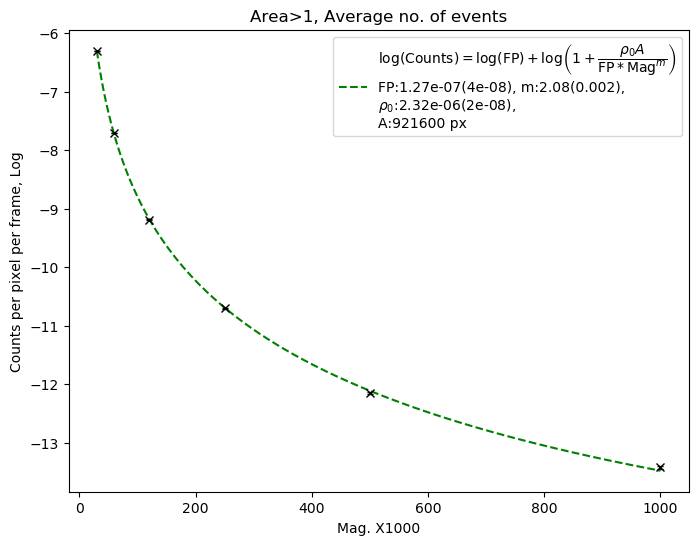

In [109]:
popt_linFPlog_err = fitplotavg(FPfunclog,x,yl,area=512*(4000-2200),title='Area>1, Average no. of events',return_popterr=True)

# Estimating backscattering

We simulate a series of primary and secondary electron events with three main parameters, the total number of events per frame, the ratio of primary-to-backscattered events and the distribution model for nearest distance between a backscattered and a primary event. Comparing the histograms of nearest neighbor distances between events tabulated for both simulated and actual data allows us to determine an upper and lower bound on the parameter values.

##### Here, we extract the coordinates of the counted electron events, after the per pixel gain calibration, for a subset of 500 randomly selected frames. Similar to before, the region of interest is from column 2200 onwards. Next, we calculate the nearest neighbour distance for the events in each frame.

In [66]:
bdata_bmedrdm500_2200to_count67_coord = {}
for l in np.arange(500):
    bdata_bmedrdm500_2200to_count67_coordlist = []

    for rr in np.array(bdata_bmed_medsub1by256_1792to_counttopNNp1[idx[l]]):
        if rr[1] >= (2200-1792) and rr[2] > 0:
            bdata_bmedrdm500_2200to_count67_coordlist.append((np.int16(rr[0]),np.int16(rr[1])))
            
    bdata_bmedrdm500_2200to_count67_coord[l] = bdata_bmedrdm500_2200to_count67_coordlist

In [67]:
def calnndist(simcoorddict):
    simcoordnearestdist = []
    for k,v in simcoorddict.items():
        nbrs = NearestNeighbors(n_neighbors=5,n_jobs=None).fit(v)
        distances,_ = nbrs.kneighbors(v)
        for d in distances[:,1:]:
            idx = 0
            while not(d[idx]>1):
                idx += 1
            if d[idx]>1:
                simcoordnearestdist.append(d[idx])
            else:
                print('No nn up to {}'.format(idx))
    return simcoordnearestdist

In [68]:
bdata_bmedrdm500_2200to_count67_distintarr = calnndist(bdata_bmedrdm500_2200to_count67_coord)

##### Here with the total number of events across all 500 frames, and the number of events in each frame, we can generate simulated coordinates for each frame given a primary-to-backscattered events ratio. We also generate a list of nearest neighbor distances between a backscattered event and a primary event, assuming these distances follows an exponential distribution in all direction. Through randomly selecting a simulated primary event, we add this distance to its coordinates to generate a backscattering event.

In [69]:
exptallcoordlen = len(bdata_bmedrdm500_2200to_count67_distintarr)

In [70]:
expt_dictlenlist = tuple(len(v) for k,v in bdata_bmedrdm500_2200to_count67_coord.items())

In [71]:
int_array = types.int64[:,::1]
int_array1d = types.int32

In [72]:
@njit
def simuprimary(primarytobsratio,expt_dict=expt_dictlenlist):
    
    simcoordcoorddict = Dict.empty(
        key_type=int_array1d,
        value_type=int_array,
    )
    k = 0
    for l in expt_dict:    
        primarylength = l-np.int16(np.round(l/primarytobsratio))
        
        simcoord = np.zeros((primarylength,2),dtype=np.int64)
        
        for s in np.arange(primarylength):
            x = np.array((np.random.randint(0,high=512),
                           np.random.randint(2200-1792,high=2208)))
            simcoord[s,:] = x
        simcoordcoorddict[k] = simcoord 
        k += 1
            
    return simcoordcoorddict

In [79]:
@njit
def gencoordanglelist(l,s,simcoordcoorddict,total_events=exptallcoordlen):
    
    coordlen = np.zeros(len(simcoordcoorddict))
    for c in np.arange(len(simcoordcoorddict)):
        coordlen[c] = len(simcoordcoorddict[c])
        
    bs_coordlen = exptallcoordlen - np.int64(np.sum(coordlen))

    expdist = np.zeros((bs_coordlen))
    for b in np.arange(bs_coordlen):
        expdist[b] = np.random.exponential(scale=s)+l
    
    rdm_theta = np.zeros((bs_coordlen))
    for r in np.arange(bs_coordlen):
        rdm_theta[r] = (2*np.pi - 0) * np.random.random_sample()  

    coordnormxyanglelist = np.asarray([(int(coord[0]),int(coord[1])) for coord in zip((expdist*np.cos(rdm_theta)),
    (expdist*np.sin(rdm_theta)))])

    return coordnormxyanglelist

In [80]:
@njit
def addbscoord(simcoorddict,coordnormops,primarytobsratio,expt_dict=expt_dictlenlist):
    
    simcoorddict_bs = Dict.empty(
        key_type=int_array1d,
        value_type=int_array,
    )
    coordnormops_idx = 0
    for k,v in simcoorddict.items():
        bscoords = []
        num_coord = np.int16(np.round(expt_dict[k]/primarytobsratio)) 
        
        rdm_len_filter = np.arange(len(v))
        np.random.shuffle(rdm_len_filter)
            
        coordframecount = 0
        idx = 0

        while coordframecount < num_coord:
            
            addx = v[rdm_len_filter[idx]][0]+coordnormops[coordnormops_idx][0]
            addy = v[rdm_len_filter[idx]][1]+coordnormops[coordnormops_idx][1]
            if (addx >= 0) and (addx <= 512-1) and (addy >= 2200-1792) and (addy <= 2208-1):
                bscoords.append((addx,addy))
                coordnormops_idx += 1
                coordframecount += 1
                idx += 1
            else:
                idx += 1

                    
        if coordframecount == num_coord:
            simlist = v 
            simlist = np.vstack((simlist,np.asarray(bscoords)))
        else:
            print('Insufficient coords. for frame ',k)
            
        simcoorddict_bs[k] = simlist

    return simcoorddict_bs

In [81]:
@njit
def gensimu(l,s,primarybsratio,expt_dict=expt_dictlenlist,total_events=exptallcoordlen):
    
    simucoords = simuprimary(primarybsratio, expt_dict)
    coordanglelist = gencoordanglelist(l,s,simucoords,total_events)
    simucoordsbs = addbscoord(simucoords,coordanglelist,primarybsratio,expt_dict)
    
    return simucoords,simucoordsbs

##### The simulation is repeated to generate electron events for different parameter values, specifically the primary-to-backscattered ratio and the scale and shift parameters for the exponential distribution model for nearest distance between a backscattered and a primary event.

In [82]:
dicttype = types.DictType(types.int32,types.int64[:,::1])

In [83]:
@njit 
def loopgensimu(lrange,pbsrange,srange):
    
    simcoordictndictbs = Dict.empty(
        key_type=int_array1d,
        value_type= dicttype
    )
    
    lnum = lrange[1]-lrange[0]
    pbsnum = pbsrange[1]-pbsrange[0]
    snum = srange[1]-srange[0]
    idx = 0
    for l in prange(lnum):
        for ratio in prange(pbsnum):
            for s in prange(snum):
                simu, simubs = gensimu((l+lrange[0])*0.1,(s+srange[0])*0.1,(ratio+pbsrange[0])*0.1)
                simcoordictndictbs[idx] = simubs #int(10*(l+ratio+s))
                idx += 1

    return simcoordictndictbs

In [84]:
t = time.time()
simcoordictbs = loopgensimu(np.array((0,1)),np.array((60,131)),np.array((30,137)))
print('t:{:.3f}s'.format(time.time()-t))

t:60.071s


##### We calculate the nearest neighbor distances between the simulated events in each frame, tabulate them across all the frames, and compared them with the nearest neighbor distances calculated from the experimental data. Two-sample Kolmogorov–Smirnov (K-S) test was employed and the D-statistic obtained quantifies the difference between them. 

In [85]:
t = time.time()
datalist = []
for k,v in simcoordictbs.items():
    vdict = {}
    for kk,vv in v.items():
        vdict[kk] = vv
    datalist.append(vdict)
print('t:{:.3f}s'.format(time.time()-t))

t:12.798s


In [ ]:
pool = Pool()
t = time.time()
with Pool() as pool:
    nnrs = pool.map(calnndist,datalist)
    pool.close()
    pool.join()
    
print('NN:{:.3f}s'.format(time.time()-t))

In [91]:
t = time.time()
simcoordbsks = {}
for k,r in enumerate(nnrs):
    simcoordbsks[k] = scipy.stats.ks_2samp(bdata_bmedrdm500_2200to_count67_distintarr,r)
print('t:{:.3f}s'.format(time.time()-t))

t:125.160s


##### Finding the parameter values that gives the smallest D-statistic from K-S test

In [92]:
def dictkeytoparams(lrange,pbsrange,srange):
    idxdict = {}
    idx = 0
    for l in np.arange(lrange[0],lrange[1],1):
        for ratio in np.arange(pbsrange[0],pbsrange[1],1):
            for s in np.arange(srange[0],srange[1],1):
                idxdict['{:.1f},{:.1f},{:.1f}'.format(l*0.1,ratio*0.1,s*0.1)] = idx
                idx += 1
    return idxdict

In [93]:
idxdict = dictkeytoparams(np.array((0,1)),np.array((60,131)),np.array((30,137)))

In [95]:
allparams = (131-60)*(137-30)

In [96]:
ksstatdict = np.zeros((allparams,2))
for k,v in simcoordbsks.items():
    ksstatdict[k] = v

In [97]:
for k,v in idxdict.items():
    if v == np.argmin(ksstatdict[:,0]):
        kk = k.split(',')
        print('Loc: {}, Ratio: {}, Scale: {}'.format(*kk))

Loc: 0.0, Ratio: 9.9, Scale: 7.9


##### We performed parameter sweeps for primary-to-backscattered events ratio, from 6 to 13 in steps of 0.1, and for the scale parameter in the exponential distribution in nearest neighbor distance between a primary and a backscattered event, from 3 to 13.6 in steps of 0.1, with the location parameter of the exponential distribution kept as 0. For each parameter value, simulations were repeated 100 times, randomly generating simulated primary and backscattered events each time.  

##### Here we load our pre-calculated D-statistic from K-S test for all the 100 simulation runs of each parameter value.

In [98]:
save_pre = './examples/bdata_ks/120K_bdata4_bmedrdm500_count67_f0_all500frames_2200to_coord_simu_sweepbsrationexps_addbsdict_l0_bsr6to13d1_s3to13d7'

In [99]:
loadlist = [str(a) for a in np.arange(1,101)]

In [100]:
ksparamsdict_all = {}
for filesuf in loadlist:
    ksparamsdict_all[filesuf] = np.load(save_pre+'_'+'ksdictred'+filesuf+'.npy',allow_pickle=True)[()]

In [101]:
ksparamsdict_allarr = np.zeros((len(loadlist),allparams,2))
for k,v in ksparamsdict_all.items():
    for kk,vv in v.items():
        n = int(k) - 1 
        ksparamsdict_allarr[n,kk,:] = vv

In [102]:
ksparams_plotmap = np.ones((140,170))*-1
for k,v in idxdict.items():
    kval = k.split(',')
    ks_arrd = ksparamsdict_allarr[:,v,0]
    ksparams_plotmap[int(float(kval[1])*10),int(float(kval[2])*10)] = np.min(ks_arrd)

/scratch/loh/apps/anaconda3/envs/nkfenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


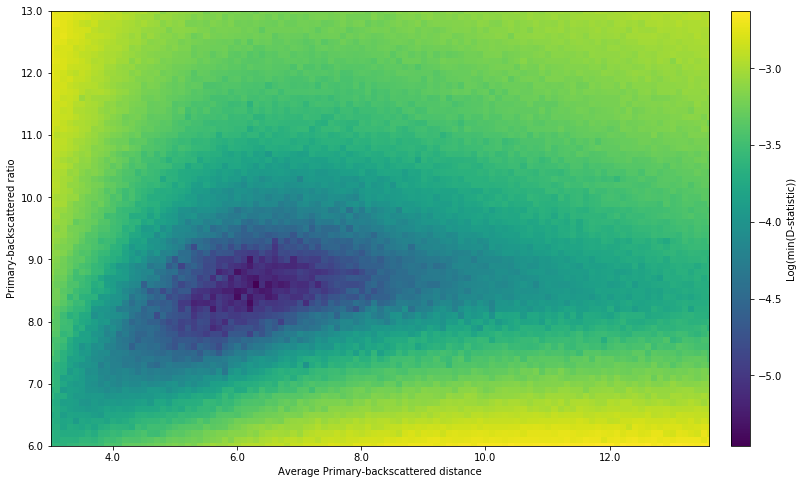

In [301]:
f,ax = plt.subplots(1,1,figsize=(14,8))
im = ax.imshow(np.log(ksparams_plotmap))

ax.set_xlim(30,136)
ax.set_xticklabels(labels=np.arange(2.0,16.0,2))
ax.set_xlabel('Average Primary-backscattered distance')

ax.set_ylim(60,130)
ax.set_yticklabels(labels=np.arange(6.0,14.0,1))
ax.set_ylabel('Primary-backscattered ratio')


div = make_axes_locatable(ax)
cax = div.append_axes("right", size="3%", pad=0.3)
cb = f.colorbar(im,cax=cax, pad=0.05)
cb.set_label('Log(min(D-statistic))')


##### Determining combined q-value using Fisher's method for all 100 simulations.

In [104]:
fisherchiq = np.zeros((allparams,2))
for q in np.arange(allparams):
    ks_arr = ksparamsdict_allarr[:,q,:]
    smtf, smpval = sm.stats.fdrcorrection(ks_arr[:,1])
    fisherchiq[q] = scipy.stats.combine_pvalues(smpval, method='fisher')

In [105]:
paramskey = np.argmax(fisherchiq[:,1])

In [106]:
for k,v in idxdict.items():
    if v == paramskey:
        kk = k.split(',')
        print('Loc: {}, Ratio: {}, Scale: {}'.format(*kk))

Loc: 0.0, Ratio: 8.7, Scale: 6.4


In [107]:
runidx = np.argwhere(ksparamsdict_allarr[:,paramskey,0]==ksparamsdict_allarr[:,paramskey,0].min())[0][0]

In [108]:
simcoorddictbsideal = np.load(save_pre+'_'+str(runidx+1)+'.npy',allow_pickle=True)[()]

In [109]:
simcoordnndistideal = calnndist(simcoorddictbsideal[paramskey])

In [347]:
for min_nn in [0,2]:
    print('Min nn dist:{}, {}'.format(min_nn,scipy.stats.ks_2samp(bdata_bmedrdm500_2200to_count67_distintarr,np.array(simcoordnndistideal)[np.array(simcoordnndistideal)>min_nn])))

Min nn dist:0, Ks_2sampResult(statistic=0.02005477784540475, pvalue=3.642095265393479e-06)
Min nn dist:2, Ks_2sampResult(statistic=0.006073330850313252, pvalue=0.5865048394079945)


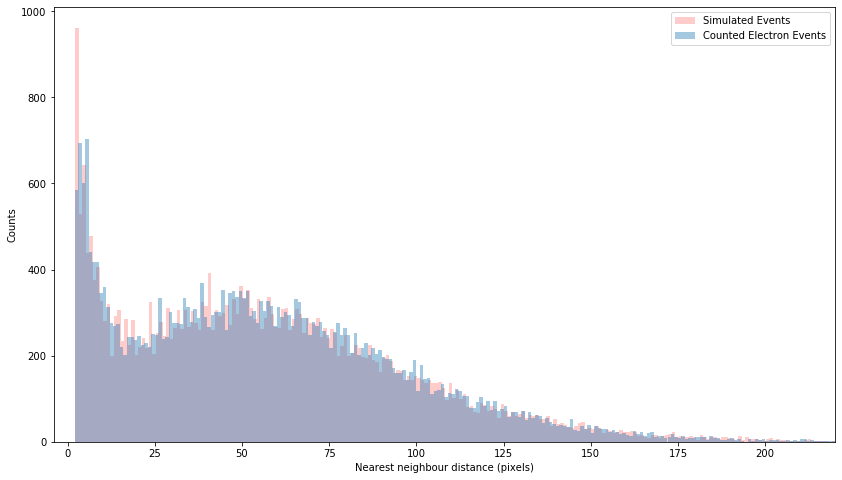

In [356]:
datatoplot0 = np.array(simcoordnndistideal)[np.array(simcoordnndistideal)>2]
datatoplot2 = np.array(bdata_bmedrdm500_2200to_count67_distintarr)

plt.figure(figsize=(14,8))

plt.hist(datatoplot0,bins=np.arange(datatoplot0.min(),datatoplot0.max()+2),color='r',density=False,alpha=0.2,label='Simulated Events');
plt.hist(datatoplot2,bins=np.arange(datatoplot2.min(),datatoplot2.max()+2),density=False,alpha=0.4,label='Counted Electron Events');

plt.xlim(-4,220)
plt.xlabel('Nearest neighbour distance (pixels)')
plt.ylabel('Counts')
plt.legend()